In [1]:
import torch
from torch import nn
from torch.utils import data
from torch.nn.utils import clip_grad_norm_
from torchvision import transforms, models
import os
import joblib
from astropy.visualization import MinMaxInterval
from astropy.io import fits
from matplotlib import pyplot as plt
import re
from glob import glob
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
import json
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
config_file = Path("config/paths.json").open('r')
paths = json.load(config_file)

In [3]:
survey_table = pd.read_csv(paths["survey_path"])

In [4]:
class_decode = ["quasar", "star", "galaxy"]

def toTableFormat(objs):
    if isinstance(objs, str):
        obj = re.sub('(^.*?galaxy/)|(^.*?star/)|(^.*?quasar/)', '', objs)
        obj = obj[:-5]
        obj_tmp = list(obj)
        obj_tmp[1] = '\''
        obj_tmp[-1] = '\''
        return ''.join(obj_tmp)
    else:
        formattedObjs = []
        for obj in objs:
            obj = re.sub('(^.*?galaxy/)|(^.*?star/)|(^.*?quasar/)', '', obj)
            obj = obj[:-5]
            obj_tmp = list(obj)
            obj_tmp[1] = '\''
            obj_tmp[-1] = '\''
            formattedObjs.append(''.join(obj_tmp))
        return formattedObjs
    
def toPathFormat(objs, objs_class, split):
    formattedObjs = []
    for obj, obj_class in zip(objs, objs_class):
        if split == "test":
            formattedObjs.append(Path(os.path.join(paths["testing_path"], class_decode[obj_class], (obj.replace('\'', '_') + ".fits"))))
        else:
            formattedObjs.append(Path(os.path.join(paths["training_path"], class_decode[obj_class], (obj.replace('\'', '_') + ".fits"))))
    return formattedObjs

In [5]:
# For objects listed in the survey table, but that could not be retrieved from the remote database
train_path_objs = list(glob("*/*.fits", root_dir=paths['training_path']))
test_objs = list(glob('*/*.fits', root_dir=paths['testing_path']))

train_path_objs = toTableFormat(train_path_objs)
test_objs = toTableFormat(test_objs)

if (isinstance(survey_table.index[0], int)):
    survey_table = survey_table.set_index('ID')

# Preparing for train/val/test split
val_idx = (survey_table.loc[train_path_objs].sampling_1 == "fold4")
train_idx = (np.logical_not(val_idx))

train_objs = list(survey_table.loc[train_path_objs][train_idx].index)
train_objs_class = list(survey_table.loc[train_path_objs][train_idx].target)

val_objs = list(survey_table.loc[train_path_objs][val_idx].index)
val_objs_class = list(survey_table.loc[train_path_objs][val_idx].target)

test_objs_class = list(survey_table.loc[test_objs].target)

## Random Forest Classifier

In [6]:
features = ["u_iso", 
            "J0378_iso", 
            "J0395_iso", 
            "J0410_iso", 
            "J0430_iso", 
            "g_iso", 
            "J0515_iso", 
            "r_iso", 
            "J0660_iso", 
            "i_iso", 
            "J0861_iso", 
            "z_iso",
            "FWHM_n",
            "A",
            "B",
            "KRON_RADIUS"]

# test_idx = survey_table["sampling_1"] == "test"
# train_idx = np.logical_not(test_idx)
X_train = survey_table.loc[train_objs][features]
y_train = train_objs_class
# X_test = survey_table.loc[test_objs][features]
# y_test = survey_table.loc[test_objs]["target"]

In [ ]:
rf = RandomForestClassifier(bootstrap=False, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
"""
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {acc*100:.4f}%")
print(f"Precision: {precision*100:.4f}%")
print(f"Recall: {recall*100:.4f}%")
print(f"F1: {f1*100:.4f}%")
"""

## CNN Model

In [ ]:
torch.manual_seed(42)

class FITSDataset(data.Dataset):
    def __init__(self, objs, objs_class, split, transforms):
        self.ids = objs
        self.img_files = toPathFormat(list(objs), objs_class, split)
        self.objs_class = objs_class
        self.transforms = transforms

    def __getitem__(self, index):
        _img = fits.getdata(self.img_files[index]).astype(np.float32)
        _label = self.objs_class[index]
        _id = self.ids[index]

        if self.transforms is not None:
            return self.transforms(_img), _label, _id

        else:
            return _img, _label, _id

    def __len__(self):
        return len(self.img_files)

def ToImage(arr):
    return Image.fromarray(arr)

def Norm(img):
    norm_tr = MinMaxInterval()
    return norm_tr(img)

fits_transform = transforms.Compose([
    transforms.Lambda(ToImage),
    transforms.Resize(size=(32, 32)),
    transforms.Lambda(Norm),
    transforms.ToTensor()
])

BATCH_SIZE = 4

train_dataset = FITSDataset(train_objs, train_objs_class, "train", fits_transform)
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)

val_dataset = FITSDataset(val_objs, val_objs_class, "val", fits_transform)
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

test_dataset = FITSDataset(test_objs, test_objs_class, "test", fits_transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

print(f"{len(train_dataloader)} train batches of {BATCH_SIZE}, {len(val_dataloader)} val batches of {BATCH_SIZE}, " +
      f"and {len(test_dataloader)} test batches of {BATCH_SIZE}")

# _data_tensor, _label_tensor = next(iter(train_dataloader))

# plt.imshow(_data_tensor[0].squeeze().numpy(), cmap='gray')
# plt.title(f"Class: {_label_tensor.numpy()[0]}");

20168 train batches of 4, 5044 val batches of 4, and 10805 test batches of 4


In [9]:
VGG16 = models.vgg16(weights='IMAGENET1K_V1')

In [ ]:
VGG16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
VGG16.classifier[6] = nn.Linear(4096, len(class_decode))

In [72]:
EPOCHS = 9
LR = 0.001
# WD = 0.0
MAX_NORM = 2.0

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

model = VGG16.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RAdam(params=model.parameters(), lr=LR)

train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in tqdm(range(EPOCHS)):
    model.train()

    train_loss.append(0.)
    train_acc.append(0.)

    for (imgs, labels, _) in train_dataloader:
        imgs, labels = imgs.to(device=device, non_blocking=True), labels.to(device=device, non_blocking=True)
        
        logits = model(imgs)
        loss = criterion(logits, labels)
        train_loss[-1] += loss.item()

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        pred_classes = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        train_acc[-1] += (pred_classes==labels).sum().item() / len(logits)
    
    train_loss[-1] /= len(train_dataloader)
    train_acc[-1] /= len(train_dataloader)
    
    test_loss.append(0.)
    test_acc.append(0.)

    model.eval()
    with torch.inference_mode():
        for (imgs, labels, _) in test_dataloader:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device=device, non_blocking=True)
            
            logits = model(imgs)
            loss = criterion(logits, labels)
            test_loss[-1] += loss.item()

            pred_classes = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            test_acc[-1] += (pred_classes==labels).sum().item() / len(logits)
        
        test_loss[-1] /= len(test_dataloader)
        test_acc[-1] /= len(test_dataloader)

    clip_grad_norm_(parameters=model.parameters(), 
                    max_norm=MAX_NORM, 
                    norm_type=2)


100%|██████████| 9/9 [02:10<00:00, 14.48s/it]


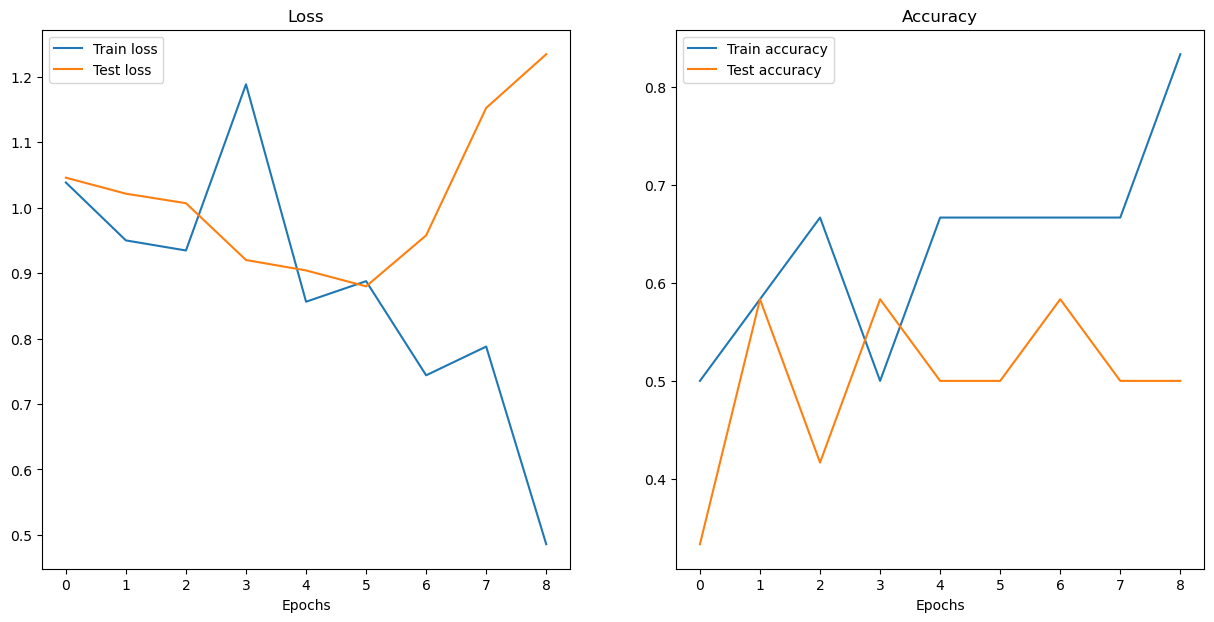

In [76]:
plt.figure(figsize=(15, 7))

epoch_range = range(EPOCHS)

plt.subplot(1, 2, 1)
plt.plot(epoch_range, train_loss, label="Train loss")
plt.plot(epoch_range, test_loss, label="Test loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, train_acc, label="Train accuracy")
plt.plot(epoch_range, test_acc, label="Test accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend();

## Ensemble model

In [ ]:
def alfa_optim(pred_probs_cnn, pred_probs_rf, y_true):
    max_score = 0
    best_alfa = 0

    # [0.00, 1.01) in steps of 0.01
    for alfa in np.arange(0, 1.01, 0.01):
        pred_probs_ensemble = alfa * pred_probs_cnn + (1 - alfa) * pred_probs_rf
        pred_classes = np.argmax(pred_probs_ensemble, axis=1)
        score = f1_score(y_true, pred_classes, average='macro')

        if score > max_score:
            max_score = score
            best_alfa = alfa
    
    return best_alfa


# DEBUG
device = 'cuda'
model = VGG16.to(device)

labels_list = []
pred_probs_cnn_list = []
pred_probs_rf_list = []

model.eval()
with torch.inference_mode():
    for (imgs, labels, ids) in tqdm(val_dataloader):
        logits = model(imgs.to(device, non_blocking=True))
        pred_probs_cnn = torch.softmax(logits, dim=1).cpu().numpy()

        pred_probs_rf = rf.predict_proba(survey_table.loc[ids, features])

        labels_list.append(labels)
        pred_probs_cnn_list.append(pred_probs_cnn)
        pred_probs_rf_list.append(pred_probs_rf)

labels_list = np.concat(labels_list)
pred_probs_cnn_list = np.concat(pred_probs_cnn_list)
pred_probs_rf_list = np.concat(pred_probs_rf_list)
best_alfa = alfa_optim(pred_probs_cnn_list, pred_probs_rf_list, labels_list)
print(f"Best alfa: {best_alfa}")

labels_list = []
pred_classes_list = []

model.eval()
with torch.inference_mode():
    for (imgs, labels, ids) in tqdm(test_dataloader):
        logits = model(imgs.to(device, non_blocking=True))
        pred_probs_cnn = torch.softmax(logits, dim=1).cpu().numpy()

        pred_probs_rf = rf.predict_proba(survey_table.loc[ids, features])

        pred_probs_ensemble = best_alfa * pred_probs_cnn + (1 - best_alfa) * pred_probs_rf
        pred_classes = np.argmax(pred_probs_ensemble, axis=1)

        labels_list.append(labels)
        pred_classes_list.append(pred_classes)

y_true, y_pred = np.concat(labels_list), np.concat(pred_classes_list)

score = f1_score(y_true, y_pred, average='macro')
print(f"F1 score: {score*100:2.2f}%")

## Model persistence

In [84]:
CNN_MODEL_NAME = f"vgg16-{LR:.4f}-{int(MAX_NORM)}-{EPOCHS}.pth".replace('.', '_', 1)
CNN_MODEL_FILEPATH = os.path.join("models", CNN_MODEL_NAME)
torch.save(obj=model.state_dict(), f=CNN_MODEL_FILEPATH)

RF_MODEL_NAME = "rf.joblib"
RF_MODEL_FILEPATH = os.path.join("models", RF_MODEL_NAME)
with open(RF_MODEL_FILEPATH, 'wb') as f:
    joblib.dump(rf, f)